In [1]:
# Imports

import pandas as pd
import biogeme.biogeme as bio
import biogeme.database as db
from biogeme import models
from biogeme.expressions import Beta
from biogeme.tools import likelihood_ratio_test
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# initialising data
df = pd.read_csv('Dataset 1 2024.csv')
df.rename(columns={'Unnamed: 0':'ID','CAR OWNERSHIP':'CAR_OWNERSHIP'}, inplace=True)
dbase = db.Database("Dataset 1 2024",df)

# Model Estimation

In [3]:
## creating the model parameters

# general parameters
BetaTT = Beta('BetaTT', 0, None, None, 0)
BetaTC = Beta('BetaTC', 0, None, None, 0)

# total cost parameters
BetaTC_car = Beta('BetaTC_car', 0, None, None, 0)
BetaTC_PT = Beta('BetaTC_PT', 0, None, None, 0)
BetaTC_cycling = Beta('BetaTC_cycling', 0, None, None, 0)
BetaTC_walking = Beta('BetaTC_walking', 0, None, None, 0)

# car alternative specific constants
Beta0_car = Beta('Beta0_car', 0, None, None, 0)
BetaTT_car = Beta('BetaTT_car', 0, None, None, 0)
BetaFuel_car = Beta('BetaFuel_car', 0, None, None, 0)
BetaParking_car = Beta('BetaParking_car', 0, None, None, 0)
BetaCongestion_car = Beta('BetaCongestion_car', 0, None, None, 0)

# public transport alternative specific constants
Beta0_PT = Beta('Beta0_PT', 0, None, None, 0)
BetaTT_PT = Beta('BetaTT_PT', 0, None, None, 0)
BetaFare_PT = Beta('BetaFare_PT', 0, None, None, 0)
BetaAC_PT = Beta('BetaAC_PT', 0, None, None, 0)
BetaAT_PT = Beta('BetaAT_PT', 0, None, None, 0)
BetaWT_PT = Beta('BetaWT_PT', 0, None, None, 0)


# cycling alternative specific constants
Beta0_cycling = Beta('Beta0_cycling', 0, None, None, 0)
BetaTT_cycling = Beta('BetaTT_cycling', 0, None, None, 0)
BetaBikeability_cycling = Beta('BetaBikeability_cycling', 0, None, None, 0)

# walking alternative specific constants
Beta0_walking = Beta('Beta0_walking', 0, None, None, 1)
BetaTT_walking = Beta('BetaTT_walking', 0, None, None, 0)
BetaWalkability_walking = Beta('BetaWalkability_walking', 0, None, None, 0)

# demographic attribute generic parameters
BetaAge = Beta('BetaAge', 0, None, None, 0)
BetaGender = Beta('BetaGender', 0, None, None, 0)
BetaIncome = Beta('BetaIncome', 0, None, None, 0)
BetaCarOwnership = Beta('BetaCarOwnership', 0, None, None, 0)


In [4]:
globals().update(dbase.variables)

In [5]:
# baseline utility functions
baseline_user = BetaAge * AGE + BetaGender * GENDER + BetaIncome * INCOME + BetaCarOwnership * CAR_OWNERSHIP

V_baseline_car = Beta0_car + BetaTT_car * TT_CAR + BetaFuel_car * FC_CAR + BetaParking_car * PC_CAR + BetaCongestion_car * CC_CAR + baseline_user
V_baseline_PT = Beta0_PT + BetaTT_PT * TT_PT + BetaFare_PT * FARE_PT + BetaAC_PT * AC_PT + BetaAT_PT * AT_PT + BetaWT_PT * WT_PT + baseline_user
V_baseline_cycling = Beta0_cycling + BetaTT_cycling * TT_CYCLE + BetaBikeability_cycling * BIKEABILITY_INDEX + baseline_user
V_baseline_walking = Beta0_walking + BetaTT_walking * TT_WALK + BetaWalkability_walking * WALKABILITY_INDEX + baseline_user

In [6]:
# generalised utility functions for chi squared test

V_baseline_car_generalised = Beta0_car + BetaTT * TT_CAR + BetaTC * (FC_CAR + PC_CAR + CC_CAR) + baseline_user
V_baseline_PT_generalised = Beta0_PT + BetaTT * TT_PT + BetaTC * (FARE_PT + AC_PT + AT_PT + WT_PT) + baseline_user
V_baseline_cycling_generalised = Beta0_cycling + BetaTT * TT_CYCLE + BetaTC * BIKEABILITY_INDEX + baseline_user
V_baseline_walking_generalised = Beta0_walking + BetaTT * TT_WALK + BetaTC * WALKABILITY_INDEX + baseline_user

In [7]:
# model that compiles all the costs together for alternative specific constants for chi squared test again

V_baseline_car_totalcost = Beta0_car + BetaTT_car * TT_CAR + BetaTC_car * (FC_CAR + PC_CAR + CC_CAR) + baseline_user
V_baseline_PT_totalcost = Beta0_PT + BetaTT_PT * TT_PT + BetaTC_PT * (FARE_PT + AC_PT + AT_PT + WT_PT) + baseline_user
V_baseline_cycling_totalcost = Beta0_cycling + BetaTT_cycling * TT_CYCLE + BetaTC_cycling * BIKEABILITY_INDEX + baseline_user
V_baseline_walking_totalcost = Beta0_walking + BetaTT_walking * TT_WALK + BetaTC_walking * WALKABILITY_INDEX + baseline_user

In [8]:
# associate utility functions with the numbering of alternatives
V_base = {4: V_baseline_car, 3: V_baseline_PT, 2: V_baseline_cycling, 1: V_baseline_walking}
V_base_generalised = {4: V_baseline_car_generalised, 3: V_baseline_PT_generalised, 2: V_baseline_cycling_generalised, 1: V_baseline_walking_generalised}
V_base_totalcost = {4: V_baseline_car_totalcost, 3: V_baseline_PT_totalcost, 2: V_baseline_cycling_totalcost, 1: V_baseline_walking_totalcost}
av = {4: 1, 3: 1, 2: 1, 1: 1}

In [9]:
# logit model
logprob_base = models.loglogit(V_base, av, CHOSEN_MODE)
logprob_base_generalised = models.loglogit(V_base_generalised, av, CHOSEN_MODE)
logprob_base_totalcost = models.loglogit(V_base_totalcost, av, CHOSEN_MODE)

In [10]:
# initialising the models
baseline = bio.BIOGEME(dbase, logprob_base)
baseline_generalised = bio.BIOGEME(dbase, logprob_base_generalised)
baseline_totalcost = bio.BIOGEME(dbase, logprob_base_totalcost)

baseline.modelName = "baseline_model"
baseline_generalised.modelName = "baseline_generalised_model"
baseline_totalcost.modelName = "baseline_totalcost_model"

In [11]:
# baseline model estimation
results_baseline = baseline.estimate()
results_baseline.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta0_PT,3.356366e+00,3.259708e-01,10.296522,0.000000e+00
Beta0_car,3.044512e+00,1.721684e-01,17.683335,0.000000e+00
Beta0_cycling,6.438489e-02,9.854961e-02,0.653325,5.135470e-01
BetaAC_PT,-5.667310e-01,4.436359e-02,-12.774690,0.000000e+00
BetaAT_PT,-9.698061e-02,9.415210e-03,-10.300419,0.000000e+00
BetaAge,-7.380632e-14,1.961691e-14,-3.762383,1.683018e-04
BetaBikeability_cycling,5.355559e-03,8.614293e-04,6.217062,5.065504e-10
BetaCarOwnership,9.515456e-17,5.295153e-15,0.017970,9.856627e-01
BetaCongestion_car,-1.294034e-01,1.293246e-02,-10.006095,0.000000e+00
BetaFare_PT,-1.137915e+00,6.898014e-02,-16.496271,0.000000e+00


In [12]:
# baseline generalised model estimation
results_baseline_generalised = baseline_generalised.estimate()
results_baseline_generalised.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta0_PT,-2.984911e+00,6.383947e-02,-4.675652e+01,0.000000e+00
Beta0_car,-9.859077e-01,3.925295e-02,-2.511678e+01,0.000000e+00
Beta0_cycling,-1.413638e-01,2.684252e-02,-5.266414e+00,1.391142e-07
BetaAge,-7.216421e-15,1.972906e-17,-3.657762e+02,0.000000e+00
BetaCarOwnership,9.274919e-18,8.778636e-20,1.056533e+02,0.000000e+00
BetaGender,1.505564e-17,4.818747e-20,3.124389e+02,0.000000e+00
BetaIncome,-9.345428e-15,1.797693e+308,-5.434722e-323,1.000000e+00
BetaTC,4.777857e-03,5.950271e-04,8.029647e+00,8.881784e-16
BetaTT,-7.317127e-02,1.178168e-03,-6.210596e+01,0.000000e+00


In [13]:
# baseline total cost model estimation
results_baseline_totalcost = baseline_totalcost.estimate()
results_baseline_totalcost.get_estimated_parameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
Beta0_PT,4.636015e-01,2.477302e-01,1.871397e+00,6.129011e-02
Beta0_car,2.515980e+00,1.575676e-01,1.596763e+01,0.000000e+00
Beta0_cycling,6.887743e-02,9.772029e-02,7.048426e-01,4.809082e-01
BetaAge,7.466399e-14,1.797693e+308,4.150151e-322,1.000000e+00
BetaCarOwnership,2.733280e-17,7.001766e-14,3.903701e-04,9.996885e-01
BetaGender,-4.750387e-16,1.797693e+308,-4.940656e-324,1.000000e+00
BetaIncome,-3.912357e-14,5.878772e-15,-6.655058e+00,2.831890e-11
BetaTC_PT,-1.081079e-01,7.208485e-03,-1.499732e+01,0.000000e+00
BetaTC_car,-1.955748e-01,9.505163e-03,-2.057564e+01,0.000000e+00
BetaTC_cycling,5.365577e-03,8.516906e-04,6.299913e+00,2.978129e-10


# Analysis

In [14]:
# extracting the general statistics
baseline_stats = results_baseline.getGeneralStatistics()
baseline_generalised_stats = results_baseline_generalised.getGeneralStatistics()
baseline_totalcost_stats = results_baseline_totalcost.getGeneralStatistics()

C:\Users\majdy\AppData\Local\Temp\ipykernel_36376\3121988993.py:2: DeprecationWarning: getGeneralStatistics is deprecated; use get_general_statistics instead.
  baseline_stats = results_baseline.getGeneralStatistics()
C:\Users\majdy\AppData\Local\Temp\ipykernel_36376\3121988993.py:3: DeprecationWarning: getGeneralStatistics is deprecated; use get_general_statistics instead.
  baseline_generalised_stats = results_baseline_generalised.getGeneralStatistics()
C:\Users\majdy\AppData\Local\Temp\ipykernel_36376\3121988993.py:4: DeprecationWarning: getGeneralStatistics is deprecated; use get_general_statistics instead.
  baseline_totalcost_stats = results_baseline_totalcost.getGeneralStatistics()


In [15]:
#likelihood ratio test between the generalised model and the baseline model

LRbase = [baseline_stats['Final log likelihood'].value, baseline_stats['Number of estimated parameters'].value]
LRgeneralised = [baseline_generalised_stats['Final log likelihood'].value, baseline_generalised_stats['Number of estimated parameters'].value]

LR_test_1 = likelihood_ratio_test(LRgeneralised, LRbase)
LR_test_1

LRTuple(message='H0 can be rejected at level 5.0%', statistic=1652.0390671734222, threshold=np.float64(19.67513757268249))

In [16]:
# likelihood ratio test between the total cost model and the baseline model

LRtotalcost = [baseline_totalcost_stats['Final log likelihood'].value, baseline_totalcost_stats['Number of estimated parameters'].value]

LR_test_2 = likelihood_ratio_test(LRtotalcost, LRbase)
LR_test_2

LRTuple(message='H0 can be rejected at level 5.0%', statistic=727.4611186908423, threshold=np.float64(11.070497693516351))

# interventions

In [17]:
# Define percentage reductions for access time
percentage_times = np.linspace(0, 1, 21)
percentage_costs = np.linspace(0, 1, 21)

# Define age groups
age_bins = [18, 25, 35, 45, 55, 65, 71]  # Note: upper bound is exclusive
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-70']

# Add a new column to the dataframe for age groups
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

# Define unique genders in your dataset
genders = df['GENDER'].unique()

In [18]:
# Calculate total number of observations
total_observations = len(df)

# Calculate proportion for each gender
gender_counts = df['GENDER'].value_counts()
gender_proportions = gender_counts / total_observations

# Calculate proportion for each age group
age_group_counts = df['AGE_GROUP'].value_counts()
age_group_proportions = age_group_counts / total_observations

# Display results
print("Gender Proportions:")
print(gender_proportions)

print("\nAge Group Proportions:")
print(age_group_proportions)

Gender Proportions:
GENDER
1    0.5108
2    0.4892
Name: count, dtype: float64

Age Group Proportions:
AGE_GROUP
35-44    0.1944
55-64    0.1935
25-34    0.1855
45-54    0.1827
18-24    0.1340
65-70    0.1099
Name: count, dtype: float64


In [19]:

# Initialize arrays to store market shares for each demographic segment
pt_market_share_gender_age = np.zeros((len(age_labels), len(genders), len(percentage_times), len(percentage_costs)))
cycling_market_share_gender_age = np.zeros_like(pt_market_share_gender_age)
walking_market_share_gender_age = np.zeros_like(pt_market_share_gender_age)
car_market_share_gender_age = np.zeros_like(pt_market_share_gender_age)


for age_idx, age_group in enumerate(age_labels):
    for gender_idx, gender in enumerate(genders):
        # Filter data for current demographic segment
        segment_df = df[(df['AGE_GROUP'] == age_group) & (df['GENDER'] == gender)].copy()
        segment_df['AGE_GROUP'] = segment_df['AGE_GROUP'].cat.codes
        segment_db = db.Database("Segmented Data", segment_df)
        
        # Update globals with segment-specific variables
        globals().update(segment_db.variables)

        # Repeat the intervention simulation loop for this segment
        for j, perccost in enumerate(percentage_costs):
            for i, perctime in enumerate(percentage_times):
                # Define utility function with reduced access time and demographic attributes
                V_intervention_PT = (Beta0_PT +
                                     BetaTT_PT * TT_PT +
                                     BetaFare_PT * FARE_PT +
                                     BetaAC_PT * AC_PT*(1-perccost) +
                                     BetaAT_PT * AT_PT*(1-perctime) +
                                     BetaWT_PT * WT_PT +
                                     baseline_user)
                
                # Create a new utility functions dictionary for this scenario
                V_intervention = {4: V_baseline_car, 3: V_intervention_PT, 2: V_baseline_cycling, 1: V_baseline_walking}

                simulate = {'Prob. Car': models.logit(V_intervention, av, 4),
                            'Prob. Public Transport': models.logit(V_intervention, av, 3),
                            'Prob. Cycling': models.logit(V_intervention, av, 2),
                            'Prob. Walking': models.logit(V_intervention, av, 1)}
                
                biosim_intervention = bio.BIOGEME(segment_db, simulate)
                biosim_intervention.modelName = f'intervention_time{int(perctime*100)}_cost{int(perccost*100)}_simulation'
                
                # Simulate and calculate market shares
                simulated_values = biosim_intervention.simulate(the_beta_values=results_baseline.get_beta_values())
                probabilities = simulated_values.mean(axis=0)
                
                # Normalize probabilities to ensure they sum to one
                total_probabilities = probabilities.sum()
                market_shares = probabilities / total_probabilities

                # Store the market shares into the arrays using .iloc for positional indexing
                pt_market_share_gender_age[age_idx, gender_idx, i, j] = market_shares.iloc[1]
                cycling_market_share_gender_age[age_idx, gender_idx, i, j] = market_shares.iloc[2]
                walking_market_share_gender_age[age_idx, gender_idx, i, j] = market_shares.iloc[3]
                car_market_share_gender_age[age_idx, gender_idx, i, j] = market_shares.iloc[0]

                print(f'Iteration {i,j} completed for Age Group {age_group}, Gender {gender}')


Iteration (0, 0) completed for Age Group 18-24, Gender 2
Iteration (1, 0) completed for Age Group 18-24, Gender 2
Iteration (2, 0) completed for Age Group 18-24, Gender 2
Iteration (3, 0) completed for Age Group 18-24, Gender 2
Iteration (4, 0) completed for Age Group 18-24, Gender 2
Iteration (5, 0) completed for Age Group 18-24, Gender 2
Iteration (6, 0) completed for Age Group 18-24, Gender 2
Iteration (7, 0) completed for Age Group 18-24, Gender 2
Iteration (8, 0) completed for Age Group 18-24, Gender 2
Iteration (9, 0) completed for Age Group 18-24, Gender 2
Iteration (10, 0) completed for Age Group 18-24, Gender 2
Iteration (11, 0) completed for Age Group 18-24, Gender 2
Iteration (12, 0) completed for Age Group 18-24, Gender 2
Iteration (13, 0) completed for Age Group 18-24, Gender 2
Iteration (14, 0) completed for Age Group 18-24, Gender 2
Iteration (15, 0) completed for Age Group 18-24, Gender 2
Iteration (16, 0) completed for Age Group 18-24, Gender 2
Iteration (17, 0) comple

In [20]:
# Save the market share arrays to .dat files
np.savetxt('pt_market_share.dat', pt_market_share_gender_age.reshape(-1, pt_market_share_gender_age.shape[-1]), delimiter=',')
np.savetxt('cycling_market_share.dat', cycling_market_share_gender_age.reshape(-1, cycling_market_share_gender_age.shape[-1]), delimiter=',')
np.savetxt('walking_market_share.dat', walking_market_share_gender_age.reshape(-1, walking_market_share_gender_age.shape[-1]), delimiter=',')
np.savetxt('car_market_share.dat', car_market_share_gender_age.reshape(-1, car_market_share_gender_age.shape[-1]), delimiter=',')

In [21]:
# load the market share arrays
num_age_groups = len(age_labels)  # Number of age groups
num_genders = len(genders)        # Number of genders
num_times = len(percentage_times)
num_costs = len(percentage_costs)

# Load and reshape each market share array
pt_market_share_gender_age = np.loadtxt('pt_market_share.dat', delimiter=',').reshape(num_age_groups, num_genders, num_times, num_costs)
cycling_market_share_gender_age = np.loadtxt('cycling_market_share.dat', delimiter=',').reshape(num_age_groups, num_genders, num_times, num_costs)
walking_market_share_gender_age = np.loadtxt('walking_market_share.dat', delimiter=',').reshape(num_age_groups, num_genders, num_times, num_costs)
car_market_share_gender_age = np.loadtxt('car_market_share.dat', delimiter=',').reshape(num_age_groups, num_genders, num_times, num_costs)

In [22]:
# Assuming 'df' is your DataFrame and it contains 'GENDER' and 'AGE_GROUP' columns
# Also assuming you have the market share arrays from previous simulations

# Calculate total number of observations
total_observations = len(df)

# Calculate proportions for each gender and age group
gender_age_group_counts = df.groupby(['GENDER', 'AGE_GROUP']).size()
gender_age_group_proportions = gender_age_group_counts / total_observations

# Calculate proportions for each age group and gender
age_group_gender_counts = df.groupby(['AGE_GROUP', 'GENDER']).size()
age_group_gender_proportions = age_group_gender_counts / total_observations

# Initialize arrays for aggregated market shares
pt_total_market_share_gender = np.zeros((len(genders), len(percentage_times), len(percentage_costs)))
cycling_total_market_share_gender = np.zeros_like(pt_total_market_share_gender)
walking_total_market_share_gender = np.zeros_like(pt_total_market_share_gender)
car_total_market_share_gender = np.zeros_like(pt_total_market_share_gender)

pt_total_market_share_age = np.zeros((len(age_labels), len(percentage_times), len(percentage_costs)))
cycling_total_market_share_age = np.zeros_like(pt_total_market_share_age)
walking_total_market_share_age = np.zeros_like(pt_total_market_share_age)
car_total_market_share_age = np.zeros_like(pt_total_market_share_age)

# Aggregate and scale market shares for each gender across all age groups
for gender_idx, gender in enumerate(genders):
    for age_idx, age_group in enumerate(age_labels):
        # Get the proportion of this age group within this gender
        proportion_gender_age = gender_age_group_proportions.get((gender, age_group), 0)

        # Scale and sum market shares by this proportion across genders
        pt_total_market_share_gender[gender_idx] += pt_market_share_gender_age[age_idx, gender_idx] * proportion_gender_age
        cycling_total_market_share_gender[gender_idx] += cycling_market_share_gender_age[age_idx, gender_idx] * proportion_gender_age
        walking_total_market_share_gender[gender_idx] += walking_market_share_gender_age[age_idx, gender_idx] * proportion_gender_age
        car_total_market_share_gender[gender_idx] += car_market_share_gender_age[age_idx, gender_idx] * proportion_gender_age

# Aggregate and scale market shares for each age group across all genders
for age_idx, age_group in enumerate(age_labels):
    for gender_idx, gender in enumerate(genders):
        # Get the proportion of this gender within this age group
        proportion_age_group_gender = age_group_gender_proportions.get((age_group, gender), 0)

        # Scale and sum market shares by this proportion across age groups
        pt_total_market_share_age[age_idx] += pt_market_share_gender_age[age_idx, gender_idx] * proportion_age_group_gender
        cycling_total_market_share_age[age_idx] += cycling_market_share_gender_age[age_idx, gender_idx] * proportion_age_group_gender
        walking_total_market_share_age[age_idx] += walking_market_share_gender_age[age_idx, gender_idx] * proportion_age_group_gender
        car_total_market_share_age[age_idx] += car_market_share_gender_age[age_idx, gender_idx] * proportion_age_group_gender

# Now pt_total_market_share_gender/age and others contain the scaled market shares for each demographic segment.


# Assuming you have the scaled market share arrays from previous calculations
# pt_total_market_share_gender and pt_total_market_share_age are already calculated

# Initialize arrays for grand total market shares
grand_total_pt_market_share = np.zeros((len(percentage_times), len(percentage_costs)))
grand_total_cycling_market_share = np.zeros_like(grand_total_pt_market_share)
grand_total_walking_market_share = np.zeros_like(grand_total_pt_market_share)
grand_total_car_market_share = np.zeros_like(grand_total_pt_market_share)

# Aggregate across all genders and age groups
for gender_idx in range(len(genders)):
    grand_total_pt_market_share += pt_total_market_share_gender[gender_idx]
    grand_total_cycling_market_share += cycling_total_market_share_gender[gender_idx]
    grand_total_walking_market_share += walking_total_market_share_gender[gender_idx]
    grand_total_car_market_share += car_total_market_share_gender[gender_idx]

for age_idx in range(len(age_labels)):
    grand_total_pt_market_share += pt_total_market_share_age[age_idx]
    grand_total_cycling_market_share += cycling_total_market_share_age[age_idx]
    grand_total_walking_market_share += walking_total_market_share_age[age_idx]
    grand_total_car_market_share += car_total_market_share_age[age_idx]

# Since we're summing twice (once for gender, once for age), divide by 2 to get correct totals
grand_total_pt_market_share /= 2
grand_total_cycling_market_share /= 2
grand_total_walking_market_share /= 2
grand_total_car_market_share /= 2

# Now these arrays contain the grand total market shares for each mode across the entire dataset

C:\Users\majdy\AppData\Local\Temp\ipykernel_36376\629802206.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_age_group_counts = df.groupby(['GENDER', 'AGE_GROUP']).size()
C:\Users\majdy\AppData\Local\Temp\ipykernel_36376\629802206.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_gender_counts = df.groupby(['AGE_GROUP', 'GENDER']).size()


np.float64(0.5108)

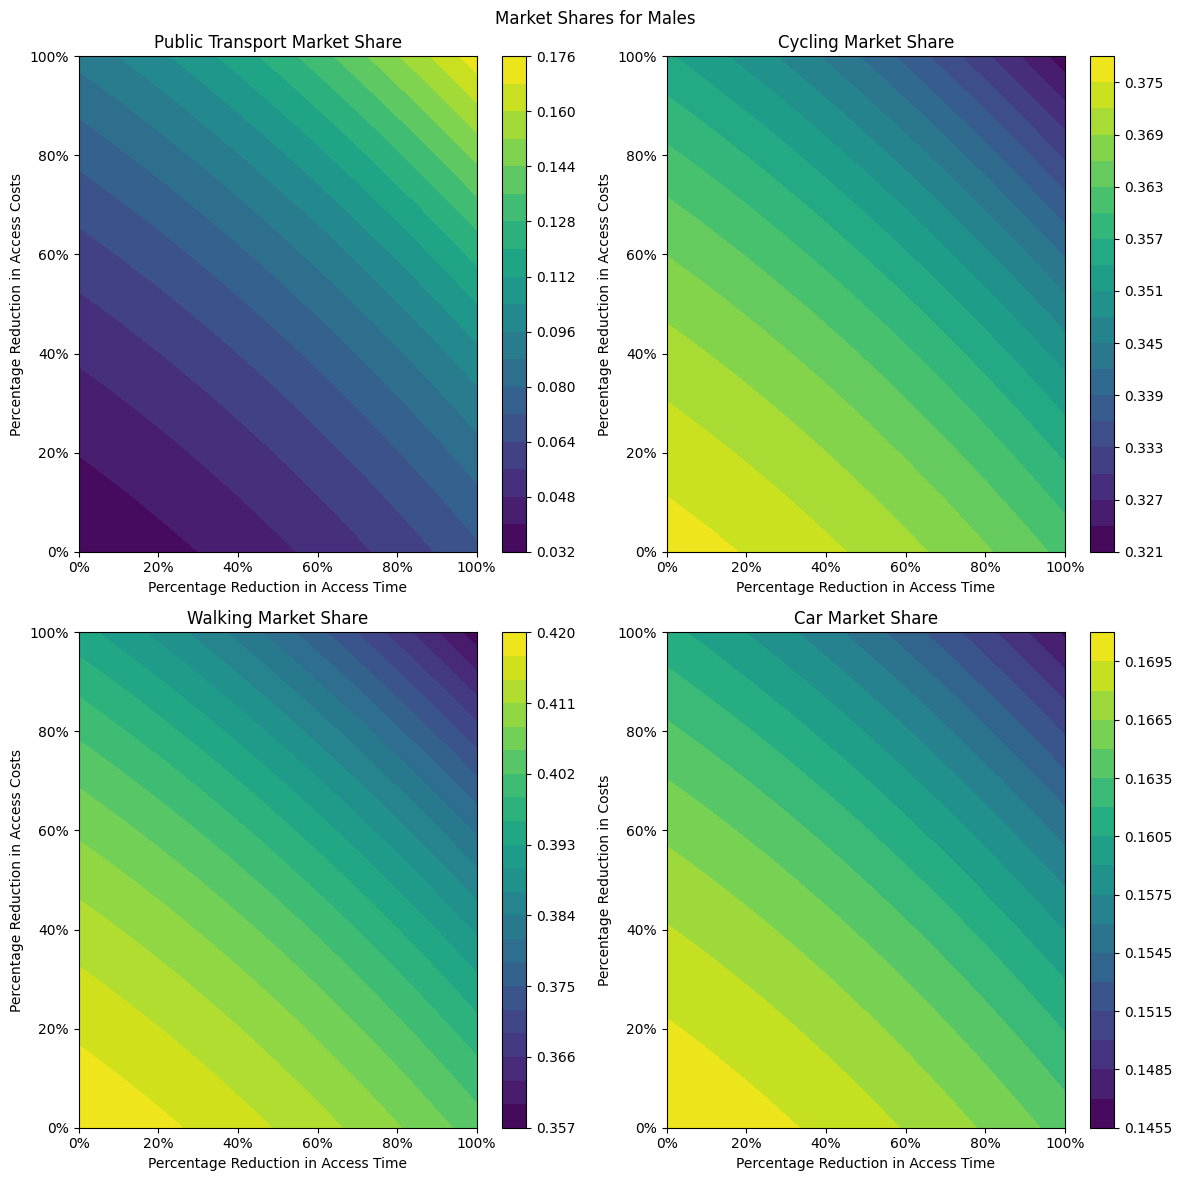

In [28]:
# plotting the market shares for each gender

from matplotlib.ticker import PercentFormatter

# meshgrid for the contour plots
X, Y = np.meshgrid(percentage_times, percentage_costs)

# contour plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle('Market Shares for Males')

# Public Transport
cs1 = axs[0, 0].contourf(X, Y, pt_total_market_share_gender[1]/gender_proportions[1], levels=20)
fig.colorbar(cs1, ax=axs[0, 0])
axs[0, 0].set_title('Public Transport Market Share')
axs[0, 0].set_xlabel('Percentage Reduction in Access Time')
axs[0, 0].set_ylabel('Percentage Reduction in Access Costs')
axs[0, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Cycling
cs2 = axs[0, 1].contourf(X, Y, cycling_total_market_share_gender[1]/gender_proportions[1], levels=20)
fig.colorbar(cs2, ax=axs[0, 1])
axs[0, 1].set_title('Cycling Market Share')
axs[0, 1].set_xlabel('Percentage Reduction in Access Time')
axs[0, 1].set_ylabel('Percentage Reduction in Access Costs')
axs[0, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 1].yaxis.set_major_formatter(PercentFormatter(1))

# Walking
cs3 = axs[1, 0].contourf(X, Y, walking_total_market_share_gender[1]/gender_proportions[1], levels=20)
fig.colorbar(cs3, ax=axs[1, 0])
axs[1, 0].set_title('Walking Market Share')
axs[1, 0].set_xlabel('Percentage Reduction in Access Time')
axs[1, 0].set_ylabel('Percentage Reduction in Access Costs')
axs[1, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Car
cs4 = axs[1, 1].contourf(X, Y, car_total_market_share_gender[1]/gender_proportions[1], levels=20)
fig.colorbar(cs4, ax=axs[1, 1])
axs[1, 1].set_title('Car Market Share')
axs[1, 1].set_xlabel('Percentage Reduction in Access Time')
axs[1, 1].set_ylabel('Percentage Reduction in Costs')
axs[1, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()



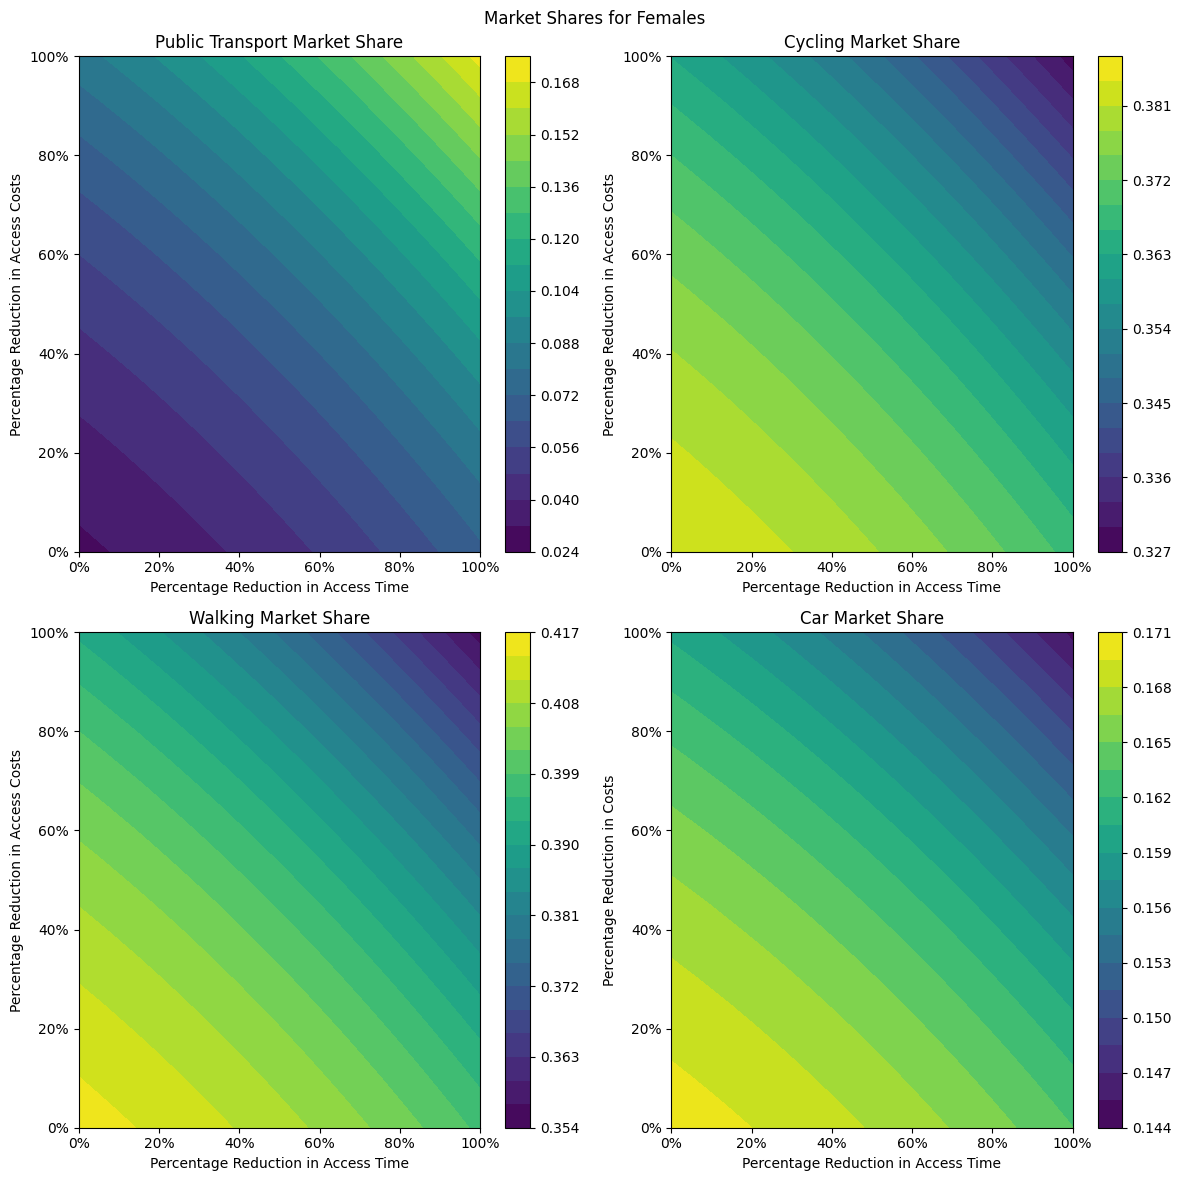

In [29]:
# plotting the market shares for each gender

# meshgrid for the contour plots
X, Y = np.meshgrid(percentage_times, percentage_costs)

# contour plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle('Market Shares for Females')

# Public Transport
cs1 = axs[0, 0].contourf(X, Y, pt_total_market_share_gender[0]/gender_proportions[2], levels=20)
fig.colorbar(cs1, ax=axs[0, 0])
axs[0, 0].set_title('Public Transport Market Share')
axs[0, 0].set_xlabel('Percentage Reduction in Access Time')
axs[0, 0].set_ylabel('Percentage Reduction in Access Costs')
axs[0, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Cycling
cs2 = axs[0, 1].contourf(X, Y, cycling_total_market_share_gender[0]/gender_proportions[2], levels=20)
fig.colorbar(cs2, ax=axs[0, 1])
axs[0, 1].set_title('Cycling Market Share')
axs[0, 1].set_xlabel('Percentage Reduction in Access Time')
axs[0, 1].set_ylabel('Percentage Reduction in Access Costs')
axs[0, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 1].yaxis.set_major_formatter(PercentFormatter(1))

# Walking
cs3 = axs[1, 0].contourf(X, Y, walking_total_market_share_gender[0]/gender_proportions[2], levels=20)
fig.colorbar(cs3, ax=axs[1, 0])
axs[1, 0].set_title('Walking Market Share')
axs[1, 0].set_xlabel('Percentage Reduction in Access Time')
axs[1, 0].set_ylabel('Percentage Reduction in Access Costs')
axs[1, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Car
cs4 = axs[1, 1].contourf(X, Y, car_total_market_share_gender[0]/gender_proportions[2], levels=20)
fig.colorbar(cs4, ax=axs[1, 1])
axs[1, 1].set_title('Car Market Share')
axs[1, 1].set_xlabel('Percentage Reduction in Access Time')
axs[1, 1].set_ylabel('Percentage Reduction in Costs')
axs[1, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()

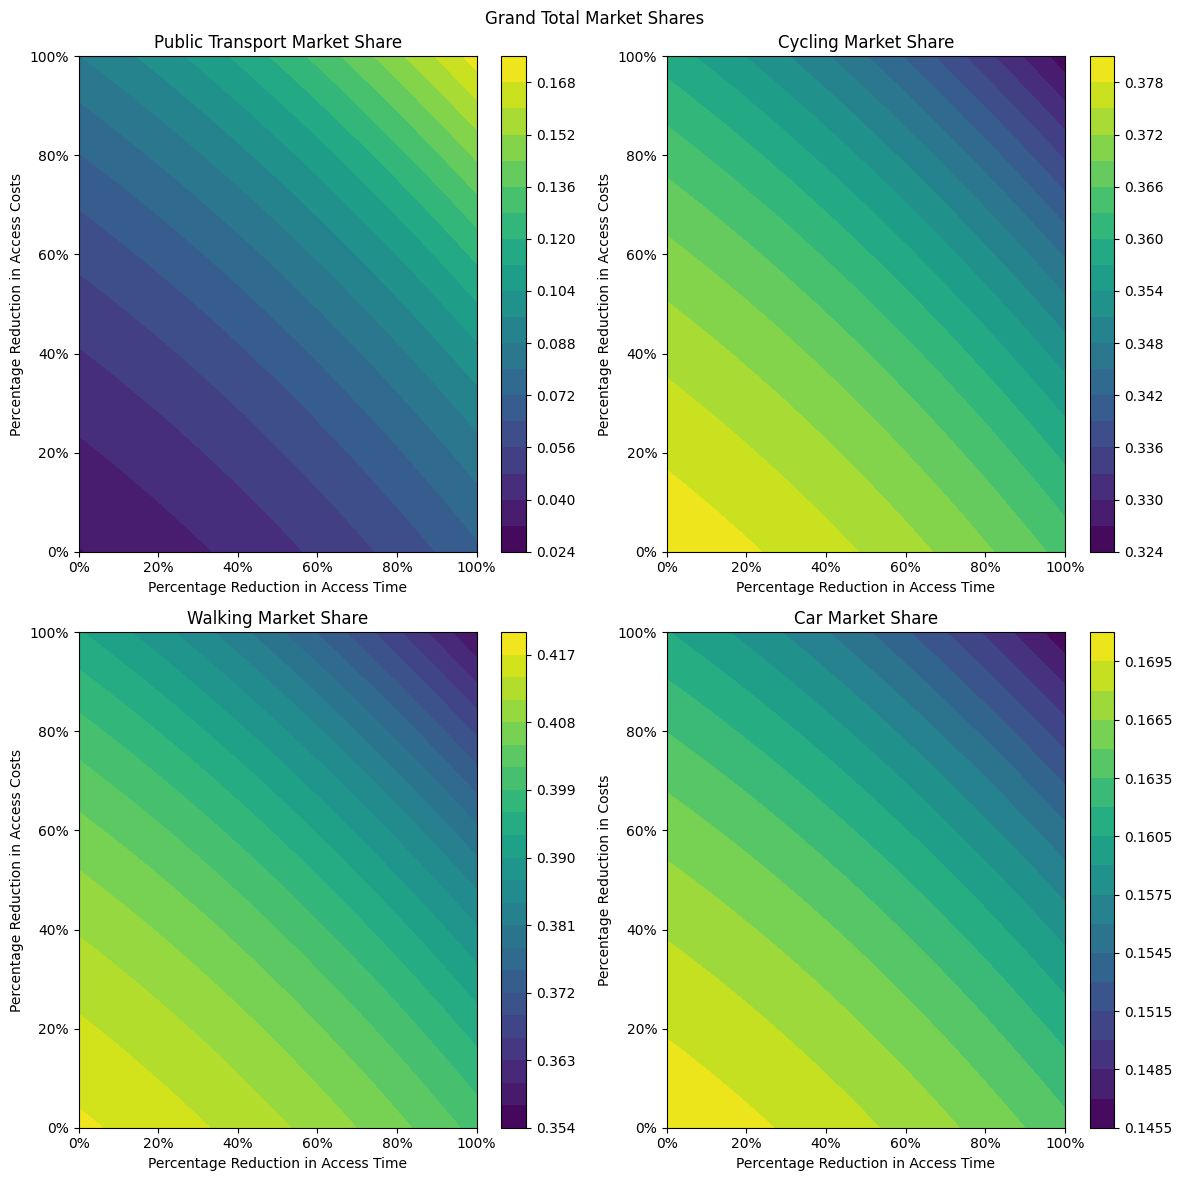

In [25]:
# plotting the grand total market shares

# meshgrid for the contour plots
X, Y = np.meshgrid(percentage_times, percentage_costs)

# contour plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

fig.suptitle('Grand Total Market Shares')

# Public Transport
cs1 = axs[0, 0].contourf(X, Y, grand_total_pt_market_share, levels=20)
fig.colorbar(cs1, ax=axs[0, 0])
axs[0, 0].set_title('Public Transport Market Share')
axs[0, 0].set_xlabel('Percentage Reduction in Access Time')
axs[0, 0].set_ylabel('Percentage Reduction in Access Costs')
axs[0, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Cycling
cs2 = axs[0, 1].contourf(X, Y, grand_total_cycling_market_share, levels=20)
fig.colorbar(cs2, ax=axs[0, 1])
axs[0, 1].set_title('Cycling Market Share')
axs[0, 1].set_xlabel('Percentage Reduction in Access Time')
axs[0, 1].set_ylabel('Percentage Reduction in Access Costs')
axs[0, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[0, 1].yaxis.set_major_formatter(PercentFormatter(1))

# Walking
cs3 = axs[1, 0].contourf(X, Y, grand_total_walking_market_share, levels=20)
fig.colorbar(cs3, ax=axs[1, 0])
axs[1, 0].set_title('Walking Market Share')
axs[1, 0].set_xlabel('Percentage Reduction in Access Time')
axs[1, 0].set_ylabel('Percentage Reduction in Access Costs')
axs[1, 0].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 0].yaxis.set_major_formatter(PercentFormatter(1))

# Car
cs4 = axs[1, 1].contourf(X, Y, grand_total_car_market_share, levels=20)
fig.colorbar(cs4, ax=axs[1, 1])
axs[1, 1].set_title('Car Market Share')
axs[1, 1].set_xlabel('Percentage Reduction in Access Time')
axs[1, 1].set_ylabel('Percentage Reduction in Costs')
axs[1, 1].xaxis.set_major_formatter(PercentFormatter(1))
axs[1, 1].yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()